# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Catinca Mujdei
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

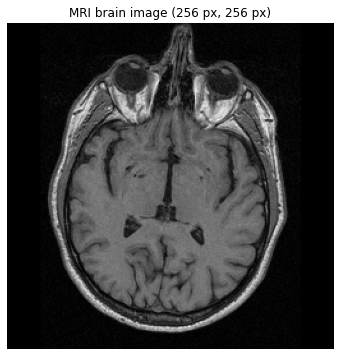

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing

By first looking at the histogram of the grey-values of the image, we can see that there are two distinct "peak regions": one close to 0 and a much more modest one around 80, the second one of which represents the gray brain mass. 

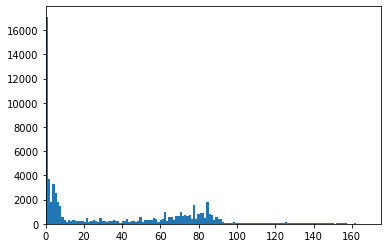

In [3]:
fig, ax = plt.subplots(1, 1)
ax.hist(brain_im.ravel(), bins=150, range=[0, 175])
ax.set_xlim(0, 175);

The function in the next cell implements the region growing technique. In our approach we consider only four neighbours in the iterations; the right, lower, left and upper one (in that sequence). This function will print the estimated number of pixels that the brain mass accounts for, as well as its fraction of the full image, and it also shows the selected pixels in white on a final image.

In [4]:
from tqdm import tqdm

def region_growing(image, seed, treshold):
    #parameters
    neighbours = [[0, 1], [1, 0], [0, -1], [-1, 0]] #only 4?
    
    to_be_checked = [seed]
    checked = []
    segmented_image = np.zeros((im_h, im_w))
    segmented_image[seed[0], seed[1]] = 255
    
    while to_be_checked:
        pixel_new = to_be_checked.pop()
        x_new = pixel_new[0]
        y_new = pixel_new[1]
        
        for i in range(4):
            x_neighbour = x_new + neighbours[i][0]
            y_neighbour = y_new + neighbours[i][1]
            neighbour = [x_neighbour, y_neighbour]
            
            if ((0 <= x_neighbour < im_w) and (0 <= y_neighbour < im_h) 
                and (abs(brain_im[x_new, y_new].astype(float) - brain_im[x_neighbour, y_neighbour].astype(float))
                     <= treshold)):
                if ((neighbour not in to_be_checked) and (neighbour not in checked)):
                    to_be_checked.append(neighbour)
                    segmented_image[x_neighbour, y_neighbour] = 255
        if (pixel_new not in checked):
            checked.append(pixel_new)
    
    number_of_brain_pixels = len(checked)
    fraction_of_total_image = number_of_brain_pixels / float(im_h * im_w)
    print('Number of brain pixels: ' + str(number_of_brain_pixels))
    print('Fraction of total image: ' + str(fraction_of_total_image))
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(segmented_image, cmap='gray')
    ax.set_title('Segmented image')
    ax.axis('off')
    plt.show()

We chose the seed to be at coordinate [100, 154], and next we decided on a treshold value (intensity difference) of 9 by calibration. [Should we compare plots of different treshold values?]

Number of brain pixels: 17354
Fraction of total image: 0.264801025390625


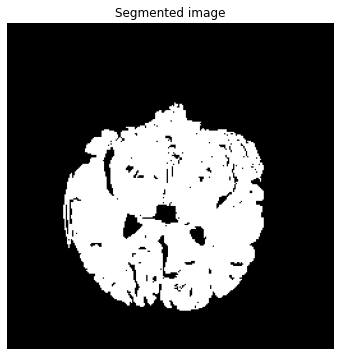

In [7]:
region_growing(brain_im, [100,154], 8)

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [99]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


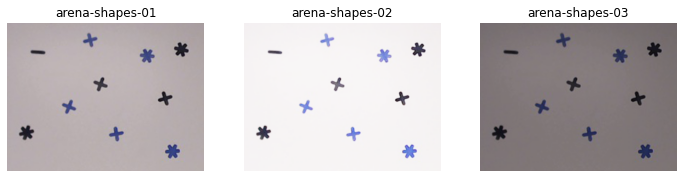

In [100]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

#### Our normalization approach
We discuss here our approach to the intensity normalization. In the implementation below, normalization can be chosen to be done either linearly or by use of the sigmoid function. 

Linear normalization (also referred to as "contrast stretching") has the disadvantage that a single outlying pixel can lead to an unrepresentative scaling. We could improve this technique by looking at the histogram of each channel, and choosing the minimum/maximum as the 0.005%/3.5% percentile, respectively; however, this introduces the risk that, by considering every channel independently, the colors will after the normalization not be represented with the same RGB ratio as before. One thing we can do to work against this is to try out different values for the percentiles until we get some results that are satisfactory enough. This is our reasoning behind the previously mentioned choice of percentiles.
    
The second, non-linear, option that makes use of the sigmoid function works as well, only in the sense that the resulting images are very similar. However, they are rather dark, which can be easily explained by the mathematical properties of the sigmoid function (and those are rather intuitive). Therefore, we prefer the linear normalization.

In [102]:
def normalize_intensity(image, linear=True):
    """
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    image = image.astype('float')    
    for i in range(image.shape[2]):
        #min_intensity = np.amin(image[:,:,:])
        #max_intensity = np.amax(image[:,:,:])
        min_intensity = np.percentile(image[:,:,i],0.005)
        max_intensity = np.percentile(image[:,:,i],3.5)
        diff = max_intensity - min_intensity
        avg = np.mean(image[:,:,i])
        if min_intensity != max_intensity:
            if linear: 
                factor = 255.0 / diff
                image[:,:,i] = (image[:,:,i] - min_intensity) * factor
            else: 
                image[:,:,i] = 255.0 / (1.0 + np.exp((avg - image[:,:,i]) / diff))
    image = np.clip(image, 0.0, 255.0)
                
    return image.astype('uint8')

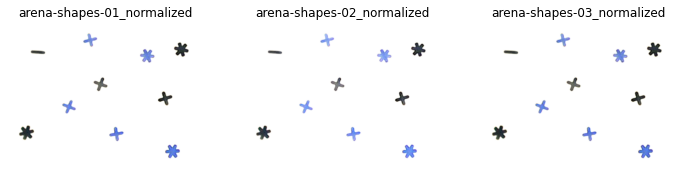

In [104]:
# Plot normalized images
im_names = ['arena-shapes-01_normalized', 'arena-shapes-02_normalized', 'arena-shapes-03_normalized']
images_normalized = np.array([normalize_intensity(images[0], True), normalize_intensity(images[1], True), 
                              normalize_intensity(images[2], True)])
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_normalized, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
1. We start by creating a binary/tresholded image of the normalized image, which is done by assigning False to all background pixels and True to all foreground pixels. (The following implementation is applied on the first image, but by changing the index to 1 or 2 in the first line in the next cell and running all other cells, one gets the same results. This is of course to be explained by the intensity normalization.)

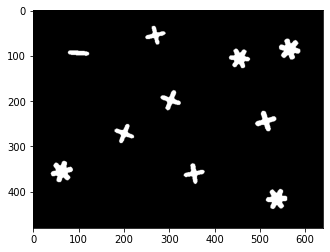

In [133]:
image = images_normalized[0] #vary the index between 0, 1 and 2 for results on all different images
im_h = image.shape[0]
im_w = image.shape[1]

mask_background = np.logical_and.reduce((image[:,:,0]>180,im[:,:,1]>180,im[:,:,2]>180))
mask_foreground = np.logical_not(mask_background)

image_binary = np.zeros((im_h, im_w))
image_binary[mask_foreground] = 255
plt.imshow(image_binary, cmap='gray')

2. We want to count the number of objects by defining an object to be a connected region. In our case, we are lucky since the images are not that noisy; all connected regions in our images define singular objects and vice versa. If this were not the case, we could have used some techniques from mathematical morphology to create fully connected regions.

3. Now that we obtained the binary image, we would like to label the individual objects (connected regions). This can be done by connected component analysis (CCA), either with 1-connectivity or 2-connectivity. We observed that 1-connectivity suffices in our case, so we stick to this choice. **Note**: The function ```skimage.measure.label``` makes our lives much easier, but we could also have implemented it ourselves of course. That is, given the foreground mask as defined in the previous cell, we can iteratively apply region growing on it, until there are no more mask pixels left unselected.

In [134]:
image_labeled, nb_labels = skimage.measure.label(image_binary, return_num=True)

4. We can now for each label extract the corresponding coordinates and check whether the specified object is either blue or black.

In [135]:
nb_black_objects = 0

for i in range(1, nb_labels + 1):
    labeled_coordinates = np.array(np.where(image_labeled == i))
    labeled_pixels = image[labeled_coordinates[0,:], labeled_coordinates[1,:]]
    black_pixels = np.logical_and.reduce((labeled_pixels[:,0] < 170, 
                                          labeled_pixels[:,1] < 170, 
                                          labeled_pixels[:,2] < 170))
    nb_labeled_pixels = labeled_coordinates.shape[1]
    nb_black_pixels = np.sum(black_pixels)
    if (nb_black_pixels / nb_labeled_pixels > 0.80):
        nb_black_objects += 1

nb_blue_objects = nb_labels - nb_black_objects

print("The image contains " + str(nb_black_objects) + " black objects and " + str(nb_blue_objects) + " blue ones.")

The image contains 5 black objects and 5 blue ones.


### 2.3 Total area (in pixels) of each color

In our attempt to solve this exercise, we considered K-means clustering: This approach was considered in order to remove the effect of non-uniformity in the displayed objects. For example, the upper blue cross in the second image shows some irregularities in its blue tone. By taking a number of 3 clusters (one cluster for background color, blue, and black), one can use functions from the Scikit-learn library to perform the clustering algorithm. However, the middle black cross in the second image was assigned some blue pixels after running the algorithm, probably because it has a strong gradient to lighter tones, which the algorithm considered to be closer to the center of the cluster representing blue. This approach was therefore discarded.

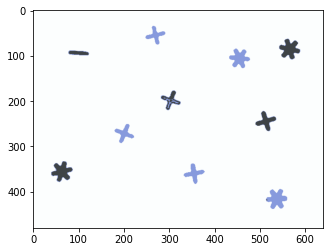

In [136]:
from sklearn.cluster import KMeans
import argparse
import cv2 as cv

image = images_normalized[1]
im_h, im_w = image.shape[:2]

image = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)

image = image.reshape((image.shape[0]*image.shape[1], 3))

clt = KMeans(n_clusters = 3)
labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

quant = quant.reshape((im_h, im_w, 3))
image = image.reshape((im_h, im_w, 3))

quant = cv.cvtColor(quant, cv.COLOR_YCrCb2BGR)
image = cv.cvtColor(image, cv.COLOR_YCrCb2BGR)

plt.imshow(quant)
plt.show()

And now for our actual approach. Due to the intensity normalization, we can more easily define boundaries for the RGB-values of the different classes 'background', 'blue' and 'black'. We can check whether our estimated boundaries are somewhat realistic, by for example, setting all pixels belonging to a certain class to a white value.

Number of blue pixels in the first image: 4836 (0.0157421875%)
Number of black pixels in the first image: 4344 (0.014140625%)


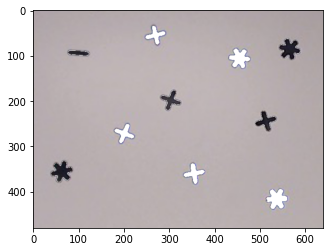

In [139]:
#Estimation of blue and black pixels for first image
image = normalize_intensity(images[0])

mask_blue = np.logical_and.reduce((image[:,:,0]<=180,im[:,:,1]<=180,im[:,:,2]>120))
mask_background = np.logical_and.reduce((image[:,:,0]>180,im[:,:,1]>180,im[:,:,2]>150))
mask_black = np.logical_not((mask_background | mask_blue))
blue = np.sum(mask_blue)
black = np.sum(mask_black)
total_area = image.shape[0] * image.shape[1]
area_fraction_blue = blue / total_area
area_fraction_black = black / total_area

print("Number of blue pixels in the first image: " + str(blue) + " (" + str(area_fraction_blue) + "%)")
print("Number of black pixels in the first image: " + str(black) + " (" + str(area_fraction_black) + "%)")

image_test = images[0].copy()
image_test[mask_blue] = 255
plt.imshow(image_test)

Number of blue pixels in the second image: 4274 (0.013912760416666666%)
Number of black pixels in the second image: 4770 (0.01552734375%)


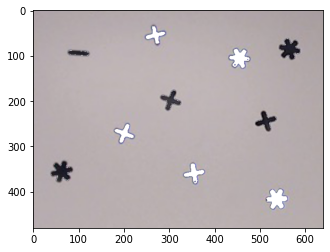

In [140]:
#Estimation of blue and black pixels for second image
image = normalize_intensity(images[1])

mask_blue = np.logical_and.reduce((image[:,:,0]<=180,im[:,:,1]<=180,im[:,:,2]>120))
mask_background = np.logical_and.reduce((image[:,:,0]>180,im[:,:,1]>180,im[:,:,2]>150))
mask_black = np.logical_not((mask_background | mask_blue))
blue = np.sum(mask_blue)
black = np.sum(mask_black)
total_area = image.shape[0] * image.shape[1]
area_fraction_blue = blue / total_area
area_fraction_black = black / total_area

print("Number of blue pixels in the second image: " + str(blue) + " (" + str(area_fraction_blue) + "%)")
print("Number of black pixels in the second image: " + str(black) + " (" + str(area_fraction_black) + "%)")

image_test = images[0].copy()
image_test[mask_blue] = 255
plt.imshow(image_test)

Number of blue pixels in the third image: 4856 (0.015807291666666667%)
Number of black pixels in the third image: 4350 (0.01416015625%)


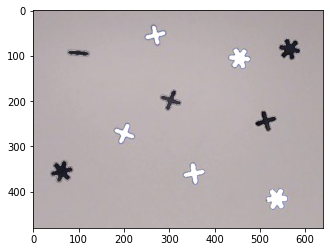

In [142]:
#Estimation of blue and black pixels for third image
image = normalize_intensity(images[2])

mask_blue = np.logical_and.reduce((image[:,:,0]<=180,im[:,:,1]<=180,im[:,:,2]>120))
mask_background = np.logical_and.reduce((image[:,:,0]>180,im[:,:,1]>180,im[:,:,2]>150))
mask_black = np.logical_not((mask_background | mask_blue))
blue = np.sum(mask_blue)
black = np.sum(mask_black)
total_area = image.shape[0] * image.shape[1]
area_fraction_blue = blue / total_area
area_fraction_black = black / total_area

print("Number of blue pixels in the third image: " + str(blue) + " (" + str(area_fraction_blue) + "%)")
print("Number of black pixels in the third image: " + str(black) + " (" + str(area_fraction_black) + "%)")

image_test = images[0].copy()
image_test[mask_blue] = 255
plt.imshow(image_test)

We thus get the following resulting numbers of blue and black pixels:

- First image: 4836 (1.57%) blue, 4344 (1.41%) black
- Second image: 4274 (1.39%) blue, 4770 (1.55%) black
- Third image: 4856 (1.58%) blue, 4350 (1.41%) black

As can be observed, the absolute estimates for the first and third image lie much closer together and seem to differ considerably from estimates for the second image; however, relatively seen (by looking at the fractions), the estimates for all three images are actually rather consistent. The differences in these numbers, however relatively small, can probably be explained by the borders of the shown objects: depending on the initial illumination of the image, the border pixels might after the intensity normalization be classified in different color classes for different images. This is visible in the image shown after the estimates for each case: the pixels contained in the borders of the black objects are partially classified as blue (but this especially occurs for the images that had less illumination initially, i.e. images 1 and 3).